In [1]:
import os
# Check if we're in the root directory of rl-llm repo
if not os.path.basename(os.getcwd()) == 'rl-llm':
    # If we're in a subdirectory of rl-llm, find the root and cd to it
    current_path = os.getcwd()
    while os.path.basename(current_path) != 'rl-llm' and os.path.dirname(current_path) != current_path:
        current_path = os.path.dirname(current_path)
    
    if os.path.basename(current_path) == 'rl-llm':
        os.chdir(current_path)
        print(f"Changed directory to: {current_path}")
    else:
        print("Not in rl-llm repository structure")
else:
    print("Already in rl-llm root directory")

print(f"Current directory: {os.getcwd()}")

Already in rl-llm root directory
Current directory: /workspace/rl-llm


In [2]:
# Import necessary libraries
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from src.env_manager import EnvManager
from src.sample_episodes import sample_episodes
from peft import PeftModel, PeftConfig
from typing import Dict, Any, List, Union
from transformers import AutoTokenizer, GenerationConfig
from trl import AutoModelForCausalLMWithValueHead
import logging
import os
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-GoTo-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-Open-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-Pickup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-PutNext-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
# Set PyTorch CUDA allocator config to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Suppress transformers logging to ERROR level
logging.getLogger("transformers").setLevel(logging.ERROR)


In [4]:
def load_model_with_peft_and_vhead(model_id, revision=None):
    """
    Load a model with both PEFT adapters and value head
    
    Args:
        model_id: Path to model or HF hub model ID
        revision: Specific model revision/commit hash to load
    
    Returns:
        model: The loaded model with adapters and value head
        tokenizer: The associated tokenizer
    """
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left', revision=revision)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    peft_config = PeftConfig.from_pretrained(model_id, revision=revision)
    base_model_id = peft_config.base_model_name_or_path
    
    logging.info(f"Loading base model: {base_model_id}")
    logging.info(f"Loading with PEFT adapters from: {model_id}")
    if revision:
        logging.info(f"Using revision: {revision}")
    
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        base_model_id,
        device_map="auto",
    )
    
    model = PeftModel.from_pretrained(model, model_id, revision=revision)
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    return model, tokenizer

In [5]:
def load_base_model_with_vhead(model_id):
    """
    Load a base model with value head
    
    Args:
        model_id: Path to model or HF hub model ID
    
    Returns:
        model: The loaded model with value head
        tokenizer: The associated tokenizer
    """
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    logging.info(f"Loading base model with value head from: {model_id}")
    
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_id,
        device_map="auto",
    )
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    return model, tokenizer

In [8]:
def evaluate(
    model,
    tokenizer,
    env_id: str,
    context_window: int,
    num_envs: int = 6,
    num_episodes: int = 40,
    reasoning_flag: bool = False,
    generation_kwargs: dict = None,
    device: torch.device = None,
    invalid_action_penalty: float = -1,
    consecutive_invalid_actions_allowed: int = 5,
    model_name: str = "model",
    step_offset: int = 0,
    num_dists: int = 0,
) -> Dict[str, Any]:
    if generation_kwargs is None:
        generation_kwargs = {
            "max_new_tokens": 20,
            "do_sample": True,
            "top_k": 50,
            "top_p": 0.9,
            "temperature": 0.7,
            "pad_token_id": tokenizer.pad_token_id
        }

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logging.info(f"Evaluating {model_name} on {env_id} with {num_episodes} episodes (reasoning={reasoning_flag}, num_dists={num_dists})")
    print(f"Evaluating {model_name} on {env_id} with {num_episodes} episodes (reasoning={reasoning_flag}, num_dists={num_dists})...")

    model.to(device)
    model.eval()

    if not hasattr(model, "generation_config"):
        model.generation_config = GenerationConfig(**generation_kwargs)

    envs = [
        EnvManager(
            env_ids=[env_id],
            num_dists=num_dists,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            reasoning_flag=reasoning_flag
        )
        for _ in range(num_envs)
    ]

    eval_start_time = time.time()
    stats, contexts = sample_episodes(
        envs=envs,
        tokenizer=tokenizer,
        model=model,
        generation_kwargs=generation_kwargs,
        device=device,
        number_of_episodes=num_episodes,
        context_window=context_window,
        reasoning_flag=reasoning_flag,
    )
    eval_end_time = time.time()

    num_samples = len(stats["success"])
    if num_samples == 0:
        metrics = {
            "num_episodes": 0,
            "success_rate": 0.0,
            "success_rate_std": 0.0,
            "avg_reward": 0.0,
            "avg_reward_std": 0.0,
            "avg_steps": 0.0,
            "avg_steps_std": 0.0,
            "invalid_action_rate": 0.0,
            "invalid_action_rate_std": 0.0,
            "avg_steps_to_success": float("nan"),
            "avg_steps_to_success_std": float("nan"),
            "avg_total_time": 0.0,
            "avg_generate_time": 0.0,
        }
        logging.warning(f"No episodes completed for {model_name} on {env_id}")
        return {
            "final_metrics": metrics,
            "running_success_rates": [],
            "running_avg_rewards": [],
            "episode_times": [],
        }

    success_tensor = torch.tensor(stats["success"], dtype=torch.float32)
    reward_tensor = torch.tensor(stats["rewards"], dtype=torch.float32)
    length_tensor = torch.tensor(stats["episode_lengths"], dtype=torch.float32)
    invalid_tensor = torch.tensor(stats["num_invalid_actions"], dtype=torch.float32)

    success_rate = success_tensor.mean().item()
    success_rate_std = success_tensor.std().item() if num_samples > 1 else 0.0
    avg_reward = reward_tensor.mean().item()
    avg_reward_std = reward_tensor.std().item() if num_samples > 1 else 0.0
    avg_steps = length_tensor.mean().item()
    avg_steps_std = length_tensor.std().item() if num_samples > 1 else 0.0
    invalid_rate = invalid_tensor.mean().item()
    invalid_rate_std = invalid_tensor.std().item() if num_samples > 1 else 0.0

    successful_indices = (success_tensor == 1)
    if successful_indices.any():
        steps_for_successes = length_tensor[successful_indices]
        avg_steps_success = steps_for_successes.mean().item()
        avg_steps_success_std = steps_for_successes.std().item() if len(steps_for_successes) > 1 else 0.0
    else:
        avg_steps_success = float("nan")
        avg_steps_success_std = float("nan")

    total_time = eval_end_time - eval_start_time
    avg_generate_time = stats.get("total_generate_time", float("nan")) / num_samples if num_samples > 0 else float("nan")

    metrics = {
        "num_episodes": num_samples,
        "success_rate": success_rate,
        "success_rate_std": success_rate_std,
        "avg_reward": avg_reward,
        "avg_reward_std": avg_reward_std,
        "avg_steps": avg_steps,
        "avg_steps_std": avg_steps_std,
        "invalid_action_rate": invalid_rate,
        "invalid_action_rate_std": invalid_rate_std,
        "avg_steps_to_success": avg_steps_success,
        "avg_steps_to_success_std": avg_steps_success_std,
        "avg_total_time": total_time,
        "avg_total_time_std": 0.0,
        "avg_generate_time": avg_generate_time,
        "avg_generate_time_std": 0.0,
    }

    logging.info(f"Metrics for {model_name} on {env_id}: {metrics}")
    return {
        "final_metrics": metrics,
        "running_success_rates": [],
        "running_avg_rewards": [],
        "episode_times": [],
    }

In [12]:
# Function for plotting bar charts
def plot_performance(
    env_ids: List[str],
    context_window: int,
    baseline_non_reasoning_results: Dict[str, float],
    baseline_reasoning_results: Dict[str, float],
    reasoning_results: Dict[str, float],
    non_reasoning_results: Dict[str, float],
    env_type: str,
    checkpoint_name: str,
):
    fig, ax = plt.subplots(figsize=(12, 6))
    n_envs = len(env_ids)
    bar_width = 0.2
    index = np.arange(n_envs)

    ax.bar(index - bar_width * 1.5, [baseline_non_reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Baseline (Non-Reasoning)", color='red', alpha=0.7)
    ax.bar(index - bar_width * 0.5, [baseline_reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Baseline (Reasoning)", color='orange', alpha=0.7)
    ax.bar(index + bar_width * 0.5, [reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Reasoning (Trained)", color='blue', alpha=0.7)
    ax.bar(index + bar_width * 1.5, [non_reasoning_results[env_id] for env_id in env_ids], 
           bar_width, label="Non-Reasoning (Trained)", color='green', alpha=0.7)

    ax.set_xlabel("Environments", fontsize=12)
    ax.set_ylabel("Success Rate", fontsize=12)
    ax.set_title(f"Model Performance Comparison (Checkpoint: {checkpoint_name}, Context Window: {context_window}, {env_type})", fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(env_ids, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    plt.close()

In [10]:
# Function to evaluate multiple models on multiple environments
def evaluate_models(
    models_info: List[Dict[str, Any]],  # Expects model_id, name, optional revision
    seen_env_ids: List[str],
    unseen_env_ids: List[str],
    context_window: int = 5,
    num_envs: int = 6,
    num_episodes: int = 40,
    generation_kwargs: dict = None,
    device: torch.device = None,
    invalid_action_penalty: float = -1,
    consecutive_invalid_actions_allowed: int = 5,
    step_offset: int = 0,
    num_dists: int = 0,
) -> tuple[Dict[str, Dict[str, Dict[int, Dict[str, Any]]]], Dict[str, Dict[str, Dict[int, Dict[str, Any]]]]]:
    if generation_kwargs is None:
        generation_kwargs = {
            "max_new_tokens": 20,
            "do_sample": True,
            "top_k": 50,
            "top_p": 0.9,
            "temperature": 0.7,
        }

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = {}
    baseline_results = {"seen": {}, "unseen": {}}
    current_step = step_offset

    # Find the baseline model info
    baseline_model_info = None
    for model_info in models_info:
        if "baseline" in model_info['name'].lower():
            baseline_model_info = model_info
            break

    if baseline_model_info is None:
        raise ValueError("Baseline (untrained) model not found in models_info.")

    # Load and evaluate baseline model
    logging.info(f"Loading baseline model: {baseline_model_info['model_id']}")
    baseline_model, baseline_tokenizer = load_base_model_with_vhead(baseline_model_info['model_id'])
    generation_kwargs["pad_token_id"] = baseline_tokenizer.pad_token_id

    for env_id in seen_env_ids:
        baseline_results["seen"][env_id] = {}
        baseline_results["seen"][env_id][context_window] = {}
        print(f"\n=== Evaluating baseline model (non-reasoning) on seen env {env_id} with context {context_window} ===")
        non_reasoning_result = evaluate(
            model=baseline_model,
            tokenizer=baseline_tokenizer,
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=False,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-non-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        baseline_results["seen"][env_id][context_window]["non_reasoning"] = non_reasoning_result["final_metrics"]
        current_step += num_episodes

        print(f"\n=== Evaluating baseline model (reasoning) on seen env {env_id} with context {context_window} ===")
        reasoning_result = evaluate(
            model=baseline_model,
            tokenizer=baseline_tokenizer,
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=True,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        baseline_results["seen"][env_id][context_window]["reasoning"] = reasoning_result["final_metrics"]
        current_step += num_episodes

    for env_id in unseen_env_ids:
        baseline_results["unseen"][env_id] = {}
        baseline_results["unseen"][env_id][context_window] = {}
        print(f"\n=== Evaluating baseline model (non-reasoning) on unseen env {env_id} with context {context_window} ===")
        non_reasoning_result = evaluate(
            model=baseline_model,
            tokenizer=baseline_tokenizer,
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=False,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-non-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        baseline_results["unseen"][env_id][context_window]["non_reasoning"] = non_reasoning_result["final_metrics"]
        current_step += num_episodes

        print(f"\n=== Evaluating baseline model (reasoning) on unseen env {env_id} with context {context_window} ===")
        reasoning_result = evaluate(
            model=baseline_model,
            tokenizer=baseline_tokenizer,
            env_id=env_id,
            context_window=context_window,
            num_envs=num_envs,
            num_episodes=num_episodes,
            reasoning_flag=True,
            generation_kwargs=generation_kwargs,
            device=device,
            invalid_action_penalty=invalid_action_penalty,
            consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
            model_name=baseline_model_info['name'] + "-reasoning",
            step_offset=current_step,
            num_dists=num_dists,
        )
        baseline_results["unseen"][env_id][context_window]["reasoning"] = reasoning_result["final_metrics"]
        current_step += num_episodes

    # Clear baseline model to free memory
    del baseline_model
    torch.cuda.empty_cache()

    # Evaluate trained models
    for model_info in models_info:
        if "baseline" in model_info['name'].lower():
            continue

        model_id = model_info['model_id']
        revision = model_info.get('revision', None)
        model_name = model_info['name']
        checkpoint_name = model_info.get('checkpoint_name', model_name)

        # Load trained model
        logging.info(f"Loading trained model: {model_id} (revision: {revision})")
        model, tokenizer = load_model_with_peft_and_vhead(model_id, revision)
        generation_kwargs["pad_token_id"] = tokenizer.pad_token_id

        results[model_name] = {"seen": {}, "unseen": {}}

        for env_id in seen_env_ids:
            results[model_name]["seen"][env_id] = {}
            results[model_name]["seen"][env_id][context_window] = {}
            print(f"\n=== Evaluating {model_name} on seen env {env_id} with context {context_window} ===")
            reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=True,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-reasoning",
                step_offset=current_step,
                num_dists=num_dists,
            )
            non_reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=False,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-non-reasoning",
                step_offset=current_step + num_episodes,
                num_dists=num_dists,
            )
            results[model_name]["seen"][env_id][context_window] = {
                "reasoning": reasoning_result["final_metrics"],
                "non_reasoning": non_reasoning_result["final_metrics"],
            }
            current_step += 2 * num_episodes

        for env_id in unseen_env_ids:
            results[model_name]["unseen"][env_id] = {}
            results[model_name]["unseen"][env_id][context_window] = {}
            print(f"\n=== Evaluating {model_name} on unseen env {env_id} with context {context_window} ===")
            reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=True,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-reasoning",
                step_offset=current_step,
                num_dists=num_dists,
            )
            non_reasoning_result = evaluate(
                model=model,
                tokenizer=tokenizer,
                env_id=env_id,
                context_window=context_window,
                num_envs=num_envs,
                num_episodes=num_episodes,
                reasoning_flag=False,
                generation_kwargs=generation_kwargs,
                device=device,
                invalid_action_penalty=invalid_action_penalty,
                consecutive_invalid_actions_allowed=consecutive_invalid_actions_allowed,
                model_name=model_name + "-non-reasoning",
                step_offset=current_step + num_episodes,
                num_dists=num_dists,
            )
            results[model_name]["unseen"][env_id][context_window] = {
                "reasoning": reasoning_result["final_metrics"],
                "non_reasoning": non_reasoning_result["final_metrics"],
            }
            current_step += 2 * num_episodes

        # Clear trained model to free memory
        del model
        torch.cuda.empty_cache()

    # Plot performance for each trained model
    for model_name, env_types in results.items():
        checkpoint_name = next((info['checkpoint_name'] for info in models_info if info['name'] == model_name), model_name)
        
        seen_reasoning = {env_id: env_types["seen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in seen_env_ids}
        seen_non_reasoning = {env_id: env_types["seen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in seen_env_ids}
        seen_baseline_reasoning = {env_id: baseline_results["seen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in seen_env_ids}
        seen_baseline_non_reasoning = {env_id: baseline_results["seen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in seen_env_ids}
        
        plot_performance(
            env_ids=seen_env_ids,
            context_window=context_window,
            baseline_non_reasoning_results=seen_baseline_non_reasoning,
            baseline_reasoning_results=seen_baseline_reasoning,
            reasoning_results=seen_reasoning,
            non_reasoning_results=seen_non_reasoning,
            env_type="Seen",
            checkpoint_name=checkpoint_name,
        )
        
        unseen_reasoning = {env_id: env_types["unseen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in unseen_env_ids}
        unseen_non_reasoning = {env_id: env_types["unseen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in unseen_env_ids}
        unseen_baseline_reasoning = {env_id: baseline_results["unseen"][env_id][context_window]["reasoning"]["success_rate"] for env_id in unseen_env_ids}
        unseen_baseline_non_reasoning = {env_id: baseline_results["unseen"][env_id][context_window]["non_reasoning"]["success_rate"] for env_id in unseen_env_ids}
        
        plot_performance(
            env_ids=unseen_env_ids,
            context_window=context_window,
            baseline_non_reasoning_results=unseen_baseline_non_reasoning,
            baseline_reasoning_results=unseen_baseline_reasoning,
            reasoning_results=unseen_reasoning,
            non_reasoning_results=unseen_non_reasoning,
            env_type="Unseen",
            checkpoint_name=checkpoint_name,
        )

    return results, baseline_results


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


=== Evaluating baseline model (non-reasoning) on seen env BabyAI-Pickup-v0 with context 5 ===
Evaluating llama-3.2-3b-baseline-non-reasoning on BabyAI-Pickup-v0 with 10 episodes (reasoning=False, num_dists=0)...
1 2 3 4 5 6 7 8 9 10 

=== Evaluating baseline model (reasoning) on seen env BabyAI-Pickup-v0 with context 5 ===
Evaluating llama-3.2-3b-baseline-reasoning on BabyAI-Pickup-v0 with 10 episodes (reasoning=True, num_dists=0)...
1 2 3 4 5 6 7 8 9 10 11 


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

/workspace/rl-llm/.venv/lib/python3.10/site-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.pretrained_model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.v_proj.lora_A.default.weight', 'base_model.model.pretrained_model.model.layers.1.self_attn.v_proj.lora_B.default.weight', 'base_model.model.pretrained_model.model.layers.2.self_attn.q_proj.lora_A.default.weight', 'base_model.model.pretrained_mode


=== Evaluating trained_model_with_reasoning on seen env BabyAI-Pickup-v0 with context 5 ===
Evaluating trained_model_with_reasoning-reasoning on BabyAI-Pickup-v0 with 10 episodes (reasoning=True, num_dists=0)...
1 2 3 4 5 6 7 8 9 10 
Evaluating trained_model_with_reasoning-non-reasoning on BabyAI-Pickup-v0 with 10 episodes (reasoning=False, num_dists=0)...
1 2 3 4 5 6 7 8 9 10 


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/plots/seen_comparison_checkpoint_410_ctx5.png'

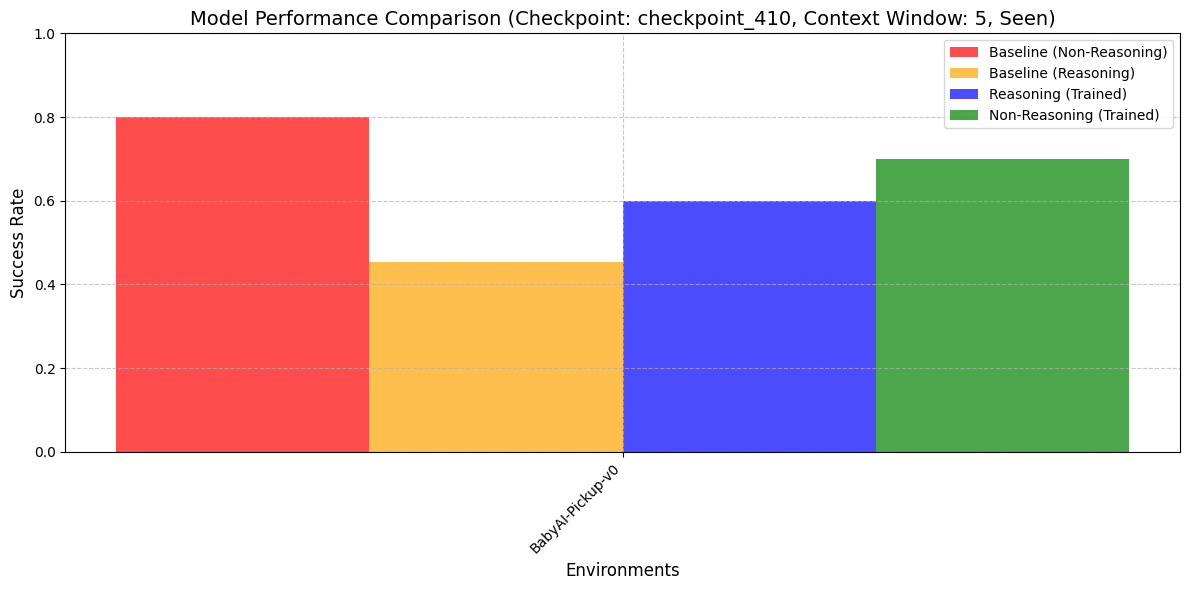

In [11]:
seen_env_ids = ["BabyAI-Pickup-v0"]
unseen_env_ids = []
models_info = [
    {
        "model_id": "meta-llama/Llama-3.2-3B-Instruct",
        "name": "llama-3.2-3b-baseline",
        "checkpoint_name": "baseline"
    },
    {
        "model_id": "CatkinChen/final_runs-Reasoning_trial_2_dist_3",
        "name": "trained_model_with_reasoning",
        "checkpoint_name": "checkpoint_410",
        "revision": "6410a502a136e20d3a4c9b61760e45da6d18855b"
    }
]

results, baseline_results = evaluate_models(
    models_info=models_info,
    seen_env_ids=seen_env_ids,
    unseen_env_ids=unseen_env_ids,
    context_window=5,
    num_envs=6,
    num_episodes=10,
    invalid_action_penalty=-1,
    consecutive_invalid_actions_allowed=5,
    num_dists=0,
)

# Print summary statistics
display(HTML("<h1>Evaluation Summary</h1>"))

# Print trained model results
for model_name, env_types in results.items():
    display(HTML(f"<h2>{model_name}</h2>"))
    
    for env_type, env_results in env_types.items():
        display(HTML(f"<h3>{env_type.capitalize()} Environments</h3>"))
        
        for env_id, context_results in env_results.items():
            display(HTML(f"<h4>{env_id}</h4>"))
            
            for cw, metrics in context_results.items():
                print(f"{model_name} on {env_id} ({env_type}) with context {cw}:")
                
                for metric_type, metric_values in metrics.items():
                    print(f"  {metric_type}:")
                    
                    for metric_name, value in metric_values.items():
                        std_key = f"{metric_name}_std"
                        if std_key in metric_values and not metric_name.endswith("_std"):
                            std_value = metric_values[std_key]
                            print(f"    {metric_name}: {value:.4f} ± {std_value:.4f}")

# Print baseline results
display(HTML("<h2>Baseline Model</h2>"))

for env_type in ["seen", "unseen"]:
    display(HTML(f"<h3>{env_type.capitalize()} Environments</h3>"))
    
    env_ids = seen_env_ids if env_type == "seen" else unseen_env_ids
    for env_id in env_ids:
        display(HTML(f"<h4>{env_id}</h4>"))
        
        print(f"llama-3.2-3b-baseline on {env_id} ({env_type}) with context {context_window}:")
        
        for metric_type in ["non_reasoning", "reasoning"]:
            print(f"  {metric_type}:")
            
            metric_values = baseline_results[env_type][env_id][context_window][metric_type]
            for metric_name, value in metric_values.items():
                if not metric_name.endswith("_std"):
                    std_key = f"{metric_name}_std"
                    if std_key in metric_values:
                        std_value = metric_values[std_key]
                        print(f"    {metric_name}: {value:.4f} ± {std_value:.4f}")
                    else:
                        print(f"    {metric_name}: {value:.4f}")
